This notebook contains the code to create Figures 1D, 2 and 4 from the main text as well as Figures S2-S5 from the Supplementary Information. It uses Python 3.8.10 and the packages SciPy (version 1.8.0), NumPy (version 1.17.4) and Matplotlib (version 3.1.2).

In [1]:
import math as m
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
from scipy.linalg import eig

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
def model(t,x):        # standard version of the model (Eqs. 1 - 5)
    Nx = x[0]
    Ny = x[1]
    Ax = x[2]
    Ay = x[3]
    Sx = x[4]
    Sy = x[5]
    Ix = x[6]
    Iy = x[7]
    
    gSx = aS*Ax/(1+aS*h*Ax)
    gSy = aS*Ay/(1+aS*h*Ay)
    
    gIx = aI*Ax/(1+aI*h*Ax)
    gIy = aI*Ay/(1+aI*h*Ay)
    
    Nxdot = D*(S-Nx) - r*Nx*Ax + dN*(Ny-Nx)
    Nydot = D*(S-Ny) - r*Ny*Ay + dN*(Nx-Ny)
    
    Axdot = r*Nx*Ax - gSx*Sx - gIx*Ix - D*Ax + dA*(Ay-Ax)
    Aydot = r*Ny*Ay - gSy*Sy - gIy*Iy - D*Ay + dA*(Ax-Ay)
    
    Sxdot = (e*gSx*Sx - D*Sx + dS*(Sy-Sx))*switch  # switch needed for numerical reasons if H_S is the
    Sydot = (e*gSy*Sy - D*Sy + dS*(Sx-Sy))*switch  # invader (then, intially switch = 0, else switch = 1)
    
    Ixdot = e*gIx*Ix - D*Ix + dI*(Iy-Ix)
    Iydot = e*gIy*Iy - D*Iy + dI*(Ix-Iy)
    
    return [Nxdot,Nydot,Axdot,Aydot,Sxdot,Sydot,Ixdot,Iydot]


def model_onepatch(t,x):      # one patch-version of the standard model (i.e., no dispersal, no inferior consumer)
    N = x[0]
    A = x[1]
    H = x[2]
    
    gH = a*A/(1+a*h*A)
        
    Ndot = D*(S-N) - r*A*N 
    Adot = r*A*N - gH*H - D*A 
    Hdot = e*gH*H - D*H 
    
    return [Ndot,Adot,Hdot]    



In [3]:
# standard parameters
S = 5
D = 0.3
r = 0.5
h = 0.5
e = 0.33
aS = 1.3
aI = 1.0
dN = 4
dA = 0.004
dS = 0.001 # no Turing instability
dI = 0.1

switch = 1 

t = np.linspace(0, 1000, 10000)
#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [0.2,0.3,0.8,0.2,0.1,0.1,0.1,0.1]


## Fig. 1D: heatmap time series $\times$ $d_{max,H}$

In [4]:
Lt = 1000  # length of time series and values of dS 
LS = 1000

tt = np.linspace(0, 500, Lt)

# first get the stable fixed point to obtain uniform starting conditions close to it
dS = 0.1
x0 = [1.7,2.2,3,1,0.2,0.2,0.,0.] # initial starting conditions, values are quite irrelevant 
X = odeint(model, x0, tt,tfirst=True)  # integrate the differential equation

x0 = X[-1]*[1.,1.,1.05,0.95,1,1,0,0] # starting conditions close to the fixed point (slightly heterogeneous!)

dS_vals = np.logspace(-2.5,0.5,LS)

x_vals = np.zeros((Lt,LS))

i = 0
for dS in dS_vals:
    X = odeint(model, x0, tt,tfirst=True)
    x_vals[i] = X[:,2]-X[:,3]
    i += 1

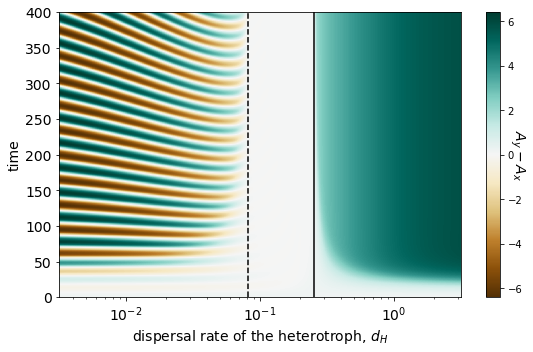

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

im = plt.pcolormesh(dS_vals,tt,np.transpose(x_vals), cmap='BrBG') #BrBG
ax.vlines(0.0809,0,500,'k',linestyle='dashed')
ax.vlines(0.253,0,500,'k',linestyle='solid')

ax.set_xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel(r"dispersal rate of the heterotroph, $d_{H}$",fontsize=14)
ax.set_ylabel("time",fontsize=14)

ax.set_ylim(0,400)

cb = plt.colorbar(im,ax=ax)
cb.set_label(label=r"$A_y - A_x$", size=14,rotation=270)

plt.tight_layout()

plt.savefig("Figure_1D.png",dpi=300)

## Fig. 4 A-D: exemplary time series showing the coexistence mechanisms

In [4]:
# standard parameters
S = 5
D = 0.3
r = 0.5
h = 0.5
e = 0.33
aS = 1.3
aI = 1.0
dN = 4
dA = 0.004

switch = 1 

t = np.linspace(0, 10000, 10000)

# A: bet-hedging (standard) - BH
dS = 0.005        # at dS = 0.005, amplitude of A w/o I is 6.2
dI = 0.018        # with dI = 0.018, amplitude of A is 6.07 w/ I

x0 = [3.2,3.2,3,1,0.2,0.2,0.05,0.05]

X_BH = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

# B: maladaptive dispersal (standard) - MD
dS = 1
dI = 0.47

x0 = [1.7,2.2,3,1,0.2,0.2,0.1,0.1]

X_MD = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

net_disp_Sx_MD = dS*(X_MD[:,5]-X_MD[:,4])  # net dispersal rates of S and I between the patches
net_disp_Ix_MD = dI*(X_MD[:,7]-X_MD[:,6])

w_S = -80*net_disp_Sx_MD[-1]                 # width of arrows depicting neet dispersal flow
w_I = -80*net_disp_Ix_MD[-1]

# C: bet-hedging with heterogeneity-modulation - BM
t1 = np.linspace(0,200,1000)
t2 = np.linspace(200.1,880,5000)
tt = np.append(t1,t2)

dS = 5e-3
dI = 1e-1

x0 = [3.2,3.2,3,1,0.2,0.2,0,0]
X_BM1 = odeint(model, x0, t1,tfirst=True)  # integrate the differential equation

x0 = X_BM1[-1] + [0,0,0,0,0,0,0.01,0.01]
X_BM2 = odeint(model, x0, t2,tfirst=True)  # integrate the differential equation

X_BM = np.append(X_BM1,X_BM2,axis=0)

# D: maladaptive dispersal with heterogeneity-modulation - MM
dS = 1
dI = 0.13

x0 = [1.7,2.2,3,1,0.3,0.2,0.01,0.01]

X_MM = odeint(model, x0, t,tfirst=True)  # integrate the differential equation

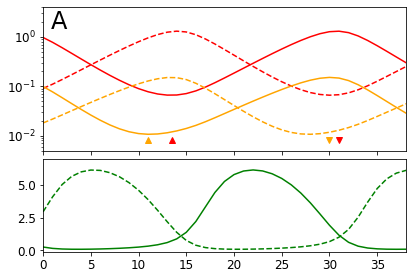

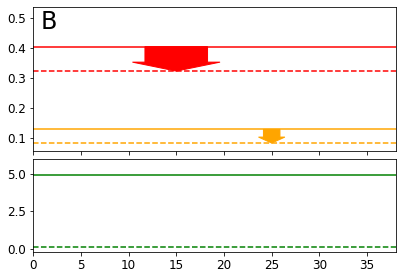

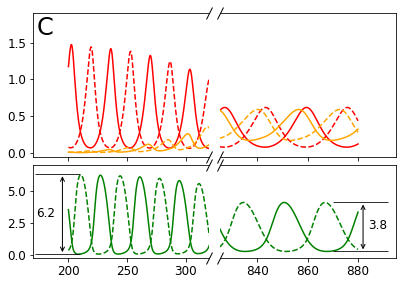

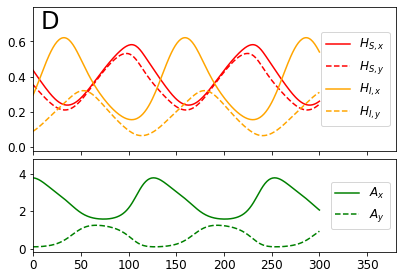

In [10]:
# plotting panels separately
# A
plt.figure(figsize=(6.5,4.5))

ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3)
ax2 = plt.subplot2grid((5,1),(3,0),rowspan=2)

ax1.plot(t-9950,X_BH[:,4],'r-',label=r'$S_x$')
ax1.plot(t-9950,X_BH[:,5],'r--',label=r'$S_y$')
ax1.plot(t-9950,X_BH[:,6],'-',color='orange',label=r'$I_x$')
ax1.plot(t-9950,X_BH[:,7],'--',color='orange',label=r'$I_y$')

ax1.plot(11,0.008,"^",color="orange")
ax1.plot(13.5,0.008,"^",color="red")
ax1.plot(30,0.008,"v",color="orange")
ax1.plot(31,0.008,"v",color="red")

ax1.set_xlim(0,38)
ax1.set_ylim(0.005,4)
ax1.set_yscale('log')
ax1.axes.xaxis.set_ticklabels([])
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.plot(t-9950,X_BH[:,2],'g-',label=r'$A_x$')
ax2.plot(t-9950,X_BH[:,3],'g--',label=r'$A_y$')

ax2.set_ylim(-0.1,7)
ax2.set_xlim(0,38)

ax2.tick_params(axis='both', which='major', labelsize=12);
ax1.text(.02, .98, 'A', ha='left', va='top', transform=ax1.transAxes,fontsize=24)
plt.savefig('Figure_4A.png',dpi=400)

# B
plt.figure(figsize=(6.5,4.5))

ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3)
ax2 = plt.subplot2grid((5,1),(3,0),rowspan=2)

ax1.plot(t-9940,X_MD[:,4],'r-',label=r'$S_x$')
ax1.plot(t-9940,X_MD[:,5],'r--',label=r'$S_y$')
ax1.plot(t-9940,X_MD[:,6],'-',color='orange',label=r'$I_x$')
ax1.plot(t-9940,X_MD[:,7],'--',color='orange',label=r'$I_y$')

ax1.arrow(15,X_MD[-1,4],0,X_MD[-1,5]-X_MD[-1,4],width = w_S,head_length = 0.03,head_width= 1.4*w_S,length_includes_head=True,color='r')
ax1.arrow(25,X_MD[-1,6],0,X_MD[-1,7]-X_MD[-1,6],width = w_I,head_length = 0.02,head_width= 1.6*w_I,length_includes_head=True,color='orange')

ax1.set_xlim(0,38)
ax1.axes.xaxis.set_ticklabels([])
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.plot(t-9940,X_MD[:,2],'g-',label=r'$A_x$')
ax2.plot(t-9940,X_MD[:,3],'g--',label=r'$A_y$')

ax2.set_xlim(0,38)
ax2.set_ylim(-0.2,6)

ax2.tick_params(axis='both', which='major', labelsize=12);
ax1.text(.02, .98, 'B', ha='left', va='top', transform=ax1.transAxes,fontsize=24)
plt.savefig('Figure_4B.png',dpi=400)

#C
plt.figure(figsize=(6.5,4.5))

ax1 = plt.subplot2grid((5,6),(0,0),rowspan=3,colspan=3)
ax2 = plt.subplot2grid((5,6),(0,3),rowspan=3,colspan=3)

ax3 = plt.subplot2grid((5,6),(3,0),rowspan=2,colspan=3)
ax4 = plt.subplot2grid((5,6),(3,3),rowspan=2,colspan=3)

ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax2.set_yticks([])

ax3.spines.right.set_visible(False)
ax4.spines.left.set_visible(False)
ax4.set_yticks([])

ax1.set_xlim(170, 320)  
ax2.set_xlim(825, 895) 
ax1.set_ylim(-0.05,1.9)
ax2.set_ylim(-0.05,1.9)

ax3.set_xlim(170, 320)  
ax4.set_xlim(825, 895)  
ax3.set_ylim(-0.2,7)
ax4.set_ylim(-0.2,7)

ax1.plot(t2,X_BM2[:,4],'r-',label=r'$S_x$')
ax1.plot(t2,X_BM2[:,5],'r--',label=r'$S_y$')
ax1.plot(t2,X_BM2[:,6],'-',color='orange',label=r'$I_x$')
ax1.plot(t2,X_BM2[:,7],'--',color='orange',label=r'$I_y$')

ax2.plot(t2,X_BM2[:,4],'r-',label=r'$S_x$')
ax2.plot(t2,X_BM2[:,5],'r--',label=r'$S_y$')
ax2.plot(t2,X_BM2[:,6],'-',color='orange',label=r'$I_x$')
ax2.plot(t2,X_BM2[:,7],'--',color='orange',label=r'$I_y$')

ax3.plot(t2,X_BM2[:,2],'g-',label=r'$A_x$')
ax3.plot(t2,X_BM2[:,3],'g--',label=r'$A_y$')

ax4.plot(t2,X_BM2[:,2],'g-',label=r'$A_x$')
ax4.plot(t2,X_BM2[:,3],'g--',label=r'$A_y$')


ax3.hlines(min(X_BM1[-1000:,2]),172,210,'k',linewidth=0.8)
ax3.hlines(max(X_BM1[-1000:,2]),172,210,'k',linewidth=0.8)
ax3.annotate("", xy=(195,max(X_BM1[-1000:,2]) ), xytext=(195,min(X_BM1[-1000:,2])), arrowprops=dict(arrowstyle="<->"))
ax3.text(173,3,str(np.round(max(X_BM1[-1000:,2])-min(X_BM1[-1000:,2]),2)),fontsize=12)

ax4.hlines(min(X_BM2[-1000:,2]),870,892,'k',linewidth=0.8)
ax4.hlines(max(X_BM2[-1000:,2]),870,892,'k',linewidth=0.8)
ax4.annotate("", xy=(882,max(X_BM2[-1000:,2]) ), xytext=(882,min(X_BM2[-1000:,2])), arrowprops=dict(arrowstyle="<->"))
ax4.text(884,2,str(np.round(max(X_BM2[-1000:,2])-min(X_BM2[-1000:,2]),2)),fontsize=12)


d = 2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([1, 1], [1, 0], transform=ax3.transAxes, **kwargs)
ax4.plot([0, 0], [0, 1], transform=ax4.transAxes, **kwargs)

ax1.tick_params(axis='y', which='major', labelsize=12);
ax3.tick_params(axis='both', which='major', labelsize=12);
ax4.tick_params(axis='x', which='major', labelsize=12);
ax1.text(.02, .98, 'C', ha='left', va='top', transform=ax1.transAxes,fontsize=24)
plt.savefig('Figure_4C.png',dpi=400)


# D
plt.figure(figsize=(6.5,4.5))

ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3)
ax2 = plt.subplot2grid((5,1),(3,0),rowspan=2)

ax1.plot(t-9700,X_MM[:,4],'r-',label=r'$H_{S,x}$')
ax1.plot(t-9700,X_MM[:,5],'r--',label=r'$H_{S,y}$')
ax1.plot(t-9700,X_MM[:,6],'-',color='orange',label=r'$H_{I,x}$')
ax1.plot(t-9700,X_MM[:,7],'--',color='orange',label=r'$H_{I,y}$')

ax1.set_ylim(-0.02,0.795)  
ax1.set_xlim(0,380)
ax1.axes.xaxis.set_ticklabels([])
ax1.tick_params(axis='y', which='major', labelsize=12);
ax2.tick_params(axis='both', which='major', labelsize=12);

ax2.plot(t-9700,X_MM[:,2],'g-',label=r'$A_x$')
ax2.plot(t-9700,X_MM[:,3],'g--',label=r'$A_y$')

ax2.set_xlim(0,380)

ax1.legend(fontsize=12,loc = 5)
ax2.legend(fontsize=12,loc = 5)
ax1.text(.02, .98, 'D', ha='left', va='top', transform=ax1.transAxes,fontsize=24)
plt.savefig('Figure_4D.png',dpi=400)


## Fig. S2: Bifurcation diagrams for the ecological parameters

In [8]:
L = 200

r_vals = np.linspace(0,1.5,L)
a_vals = np.linspace(0,3,L)
e_vals = np.linspace(0.1,0.5,L)
h_vals = np.linspace(0,1,L)

Xrmin = np.zeros((L,3))
Xrmax = np.zeros((L,3))
Xamin = np.zeros((L,3))
Xamax = np.zeros((L,3))
Xemin = np.zeros((L,3))
Xemax = np.zeros((L,3))
Xhmin = np.zeros((L,3))
Xhmax = np.zeros((L,3))

t = np.linspace(0,10000,10000)
x0 = [1,1,0.1]

S = 5
D = 0.3
r = 0.5 
h = 0.5 
a = 1.30 
e = 0.33 

for i in range(L):
    r = r_vals[i]
    X = odeint(model_onepatch, x0, t,tfirst=True)
    Xrmin[i] = [min(X[-1000:,0]),min(X[-1000:,1]),min(X[-1000:,2])]
    Xrmax[i] = [max(X[-1000:,0]),max(X[-1000:,1]),max(X[-1000:,2])]
    r = 0.5

    e = e_vals[i]
    X = odeint(model_onepatch, x0, t,tfirst=True)
    Xemin[i] = [min(X[-1000:,0]),min(X[-1000:,1]),min(X[-1000:,2])]
    Xemax[i] = [max(X[-1000:,0]),max(X[-1000:,1]),max(X[-1000:,2])]
    e = 0.33
    
    a = a_vals[i]
    X = odeint(model_onepatch, x0, t,tfirst=True)
    Xamin[i] = [min(X[-1000:,0]),min(X[-1000:,1]),min(X[-1000:,2])]
    Xamax[i] = [max(X[-1000:,0]),max(X[-1000:,1]),max(X[-1000:,2])]
    a = 1.20

    h = h_vals[i]
    X = odeint(model_onepatch, x0, t,tfirst=True)
    Xhmin[i] = [min(X[-1000:,0]),min(X[-1000:,1]),min(X[-1000:,2])]
    Xhmax[i] = [max(X[-1000:,0]),max(X[-1000:,1]),max(X[-1000:,2])]
    h = 0.5



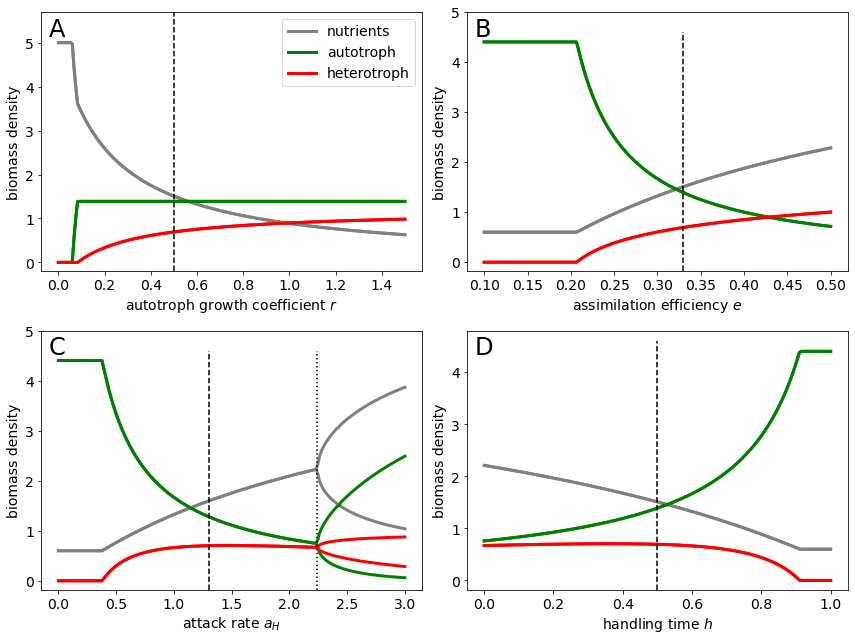

In [9]:
plt.figure(figsize=(12,9))


ax1 = plt.subplot2grid((2,2),(0,0))

ax1.plot(r_vals,Xrmin[:,0],'-',color='grey',linewidth=3,label='nutrients')
ax1.plot(r_vals,Xrmax[:,0],'-',color='grey',linewidth=3)
ax1.plot(r_vals,Xrmin[:,1],'g-',linewidth=3,label='autotroph')
ax1.plot(r_vals,Xrmax[:,1],'g-',linewidth=3)
ax1.plot(r_vals,Xrmin[:,2],'r-',linewidth=3,label='heterotroph')
ax1.plot(r_vals,Xrmax[:,2],'r-',linewidth=3)
ax1.set_xlabel('autotroph growth coefficient $r$',fontsize=14)
ax1.set_ylabel('biomass density',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.legend(fontsize=14)
ax1.vlines(0.5,-0.2,5.7,'k',linestyle='dashed')
ax1.set_ylim(-0.2,5.7)
ax1.text(.02, .98, 'A', ha='left', va='top', transform=ax1.transAxes,fontsize=24)


ax2 = plt.subplot2grid((2,2),(0,1))

ax2.plot(e_vals,Xemin[:,0],'-',color='grey',linewidth=3,label='N')
ax2.plot(e_vals,Xemax[:,0],'-',color='grey',linewidth=3)
ax2.plot(e_vals,Xemin[:,1],'g-',linewidth=3,label='A')
ax2.plot(e_vals,Xemax[:,1],'g-',linewidth=3)
ax2.plot(e_vals,Xemin[:,2],'r-',linewidth=3,label='C')
ax2.plot(e_vals,Xemax[:,2],'r-',linewidth=3)
ax2.set_xlabel('assimilation efficiency $e$',fontsize=14)
ax2.set_ylabel('biomass density',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2.vlines(0.33,-0.18,4.6,'k',linestyle='dashed')
ax2.set_ylim(-0.18,5.0)
ax2.text(.02, .98, 'B', ha='left', va='top', transform=ax2.transAxes,fontsize=24)


ax3 = plt.subplot2grid((2,2),(1,0))

ax3.plot(a_vals,Xamin[:,0],'-',color='grey',linewidth=3,label='N')
ax3.plot(a_vals,Xamax[:,0],'-',color='grey',linewidth=3)
ax3.plot(a_vals,Xamin[:,1],'g-',linewidth=3,label='A')
ax3.plot(a_vals,Xamax[:,1],'g-',linewidth=3)
ax3.plot(a_vals,Xamin[:,2],'r-',linewidth=3,label='C')
ax3.plot(a_vals,Xamax[:,2],'r-',linewidth=3)
ax3.set_xlabel('attack rate $a_H$',fontsize=14)
ax3.set_ylabel('biomass density',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax3.vlines(1.3,-0.18,4.6,'k',linestyle='dashed')
ax3.vlines(2.24,-0.18,4.6,'k',linestyle='dotted')
ax3.set_ylim(-0.18,5.0)
ax3.text(.02, .98, 'C', ha='left', va='top', transform=ax3.transAxes,fontsize=24)


ax4 = plt.subplot2grid((2,2),(1,1))

ax4.plot(h_vals,Xhmin[:,0],'-',color='grey',linewidth=3,label='N')
ax4.plot(h_vals,Xhmax[:,0],'-',color='grey',linewidth=3)
ax4.plot(h_vals,Xhmin[:,1],'g-',linewidth=3,label='A')
ax4.plot(h_vals,Xhmax[:,1],'g-',linewidth=3)
ax4.plot(h_vals,Xhmin[:,2],'r-',linewidth=3,label='C')
ax4.plot(h_vals,Xhmax[:,2],'r-',linewidth=3)
ax4.set_xlabel('handling time $h$',fontsize=14)
ax4.set_ylabel('biomass density',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax4.vlines(0.5,-0.18,4.6,'k',linestyle='dashed')
ax4.set_ylim(-0.18,4.8)
ax4.text(.02, .98, 'D', ha='left', va='top', transform=ax4.transAxes,fontsize=24)

plt.tight_layout()

plt.savefig('Figure_S2.png',dpi=300)

## Fig. S3: invasion of $H_S$ in system with $H_I$ creating oscilatory, static, or no Turing instability

In [10]:
aS = 1.3
aI = 1.0

# settings for H_I inducing oscillatory instability, H_S inducing no instability
dS = 0.15
dI = 0.02

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0.,0.,0.1,0.1]
X = odeint(model, x0, t,tfirst=True)  # integrate differential equation with only H_I present

x0 = X[-1] + [0,0,0,0,0.005,0.005,0,0]
Xo = odeint(model, x0, t,tfirst=True) 

# settings for H_I inducing no instability, H_S inducing no instability
dI = 0.10

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0.,0.,0.1,0.1]
X = odeint(model, x0, t,tfirst=True)  # integrate differential equation with only H_I present

x0 = X[-1] + [0,0,0,0,0.005,0.005,0,0]
Xno = odeint(model, x0, t,tfirst=True) 


# settings for H_I inducing static instability, H_S inducing no instability
switch = 0  # for numerical reasons: switch off dynamics for H_S during first phase
dI = 0.6

#     Nx  Ny Ax Ay Sx  Sy  Ix  Iy
x0 = [1.7,2.2,3,1,0,0,0.1,0.1]
X = odeint(model, x0, t,tfirst=True)  # integrate differential equation with only H_I present

switch = 1  # introduce H_S and switch its dynamics on again 
x0 = X[-1] + [0,0,0,0,0.0001,0.0001,0,0]
Xs = odeint(model, x0, t,tfirst=True) 

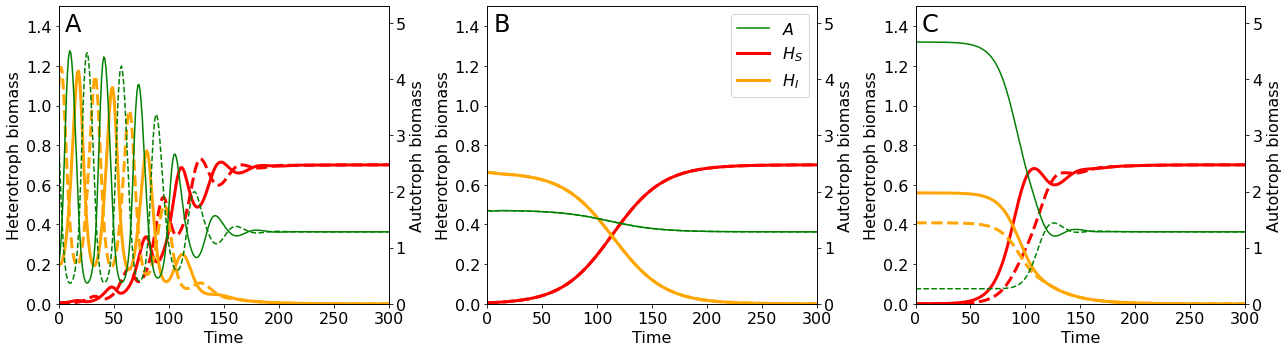

In [11]:
fig = plt.figure(figsize=(18,5))

ax1 = plt.subplot2grid((1,3),(0,0))

ax1.set_xlabel('Time', fontsize=16)
ax1.set_ylabel('Heterotroph biomass', fontsize=16)
ax1.set_xlim(0,300)
ax1.set_ylim(0,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize=16)
ax2.plot(t,Xo[:,2],'g-')
ax2.plot(t,Xo[:,3],'g--')
ax2.set_ylim(0,5.3)
ax2.set_ylabel('Autotroph biomass', fontsize=16)  # we already handled the x-label with ax2

ax1.plot(t,Xo[:,2]-100,'g-',label=r'$A$')    # dummy for the legend
ax1.plot(t,Xo[:,4],'r-',linewidth=3,label=r'$H_S$')
ax1.plot(t,Xo[:,5],'r--',linewidth=3)
ax1.plot(t,Xo[:,6],'-',linewidth=3,color='orange',label=r'$H_I$')
ax1.plot(t,Xo[:,7],'--',linewidth=3,color='orange')
ax1.text(.02, .98, 'A', ha='left', va='top', transform=ax1.transAxes,fontsize=24)


ax3 = plt.subplot2grid((1,3),(0,1))

ax3.set_xlabel('Time', fontsize=16)
ax3.set_ylabel('Heterotroph biomass', fontsize=16)
ax3.set_xlim(0,300)
ax3.set_ylim(0,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize=16)
ax4.plot(t,Xno[:,2],'g-')
ax4.plot(t,Xno[:,3],'g--')
ax4.set_ylim(0,5.3)
ax4.set_ylabel('Autotroph biomass', fontsize=16)  # we already handled the x-label with ax2

ax3.plot(t,Xno[:,2]-100,'g-',label=r'$A$')    # dummy for the legend
ax3.plot(t,Xno[:,4],'r-',linewidth=3,label=r'$H_S$')
ax3.plot(t,Xno[:,5],'r--',linewidth=3)
ax3.plot(t,Xno[:,6],'-',linewidth=3,color='orange',label=r'$H_I$')
ax3.plot(t,Xno[:,7],'--',linewidth=3,color='orange')
ax3.legend(fontsize=16)
ax3.text(.02, .98, 'B', ha='left', va='top', transform=ax3.transAxes,fontsize=24)


ax5 = plt.subplot2grid((1,3),(0,2))

ax5.set_xlabel('Time', fontsize=16)
ax5.set_ylabel('Heterotroph biomass', fontsize=16)
ax5.set_xlim(0,300)
ax5.set_ylim(0,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax6 = ax5.twinx()  # instantiate a second axes that shares the same x-axis
plt.yticks(fontsize=16)
ax6.plot(t,Xs[:,2],'g-')
ax6.plot(t,Xs[:,3],'g--')
ax6.set_ylim(0,5.3)
ax6.set_ylabel('Autotroph biomass', fontsize=16)  # we already handled the x-label with ax2

ax5.plot(t,Xs[:,2]-100,'g-',label=r'$A$')    # dummy for the legend
ax5.plot(t,Xs[:,4],'r-',linewidth=3,label=r'$H_S$')
ax5.plot(t,Xs[:,5],'r--',linewidth=3)
ax5.plot(t,Xs[:,6],'-',linewidth=3,color='orange',label=r'$H_I$')
ax5.plot(t,Xs[:,7],'--',linewidth=3,color='orange')
ax5.text(.02, .98, 'C', ha='left', va='top', transform=ax5.transAxes,fontsize=24)


plt.tight_layout()
plt.savefig('Figure_S3.png',dpi=300);

## Figs. 2 and S4: Turing boundaries in system with one consumer

In [12]:
# homogeneous fixed point (= fixed point of the one-patch system)
def FP():
    Astar = D/(a*(e-D*h))
    Nstar = D*S/(D+r*Astar)
    Hstar = (r*Nstar - D)*(1/a + h*Astar)
    
    return Nstar,Astar,Hstar

def local_Jacobian(Nsta,Astar,Hstar):
    t1 = 1/(1+a*h*Astar)
    t2 = a*Hstar*t1*t1
    t3 = a*Astar*t1
    
    return np.array([[-D-r*Astar,-r*Nstar,0],[r*Astar,r*Nstar-t2-D,-t3],[0,e*t2,0]])

def diffusion_Jacobian(dN,dA,dH):
    
    return np.array([[dN,0,0],[0,dA,0],[0,0,dH]]) 

# Turing matrix at the fixed point
def T_mat(dN,dA,dH):
    
    J_mat = local_Jacobian(Nstar,Astar,Hstar)
    D_mat = diffusion_Jacobian(dN,dA,dH)
    
    return J_mat - 2*D_mat    

# function that returns the coefficients of lambda**3 + b2*lambda**2 + b1*lambda + b0 = 0 
def coefs(dN,dA,dH):
    a11, a12, a21 = T_mat(dN,dA,dH)[0][0], T_mat(dN,dA,dH)[0][1], T_mat(dN,dA,dH)[1][0]
    a22, a23, a32 = T_mat(dN,dA,dH)[1][1], T_mat(dN,dA,dH)[1][2], T_mat(dN,dA,dH)[2][1]
    a33 = T_mat(dN,dA,dH)[2][2]
    
    b0 = a12*a21*a33 + a11*a23*a32 - a11*a22*a33
    b1 = (a11+a22)*a33 + a11*a22 - a12*a21 - a23*a32
    b2 = -(a11+a22+a33)
    
    return [b0,b1,b2]

# coefficients as functions of single parameters
def coefs_dA(dA):
    return coefs(dN,dA,dH)

def coefs_dN(dN):
    return coefs(dN,dA,dH)

def coefs_dH(dH):
    return coefs(dN,dA,dH)

# functions returning the first and third Ruth-Hurwitz criterion as a function of dH
def c1_dH(dH):    
    return coefs_dH(dH[0])[0]

def c3_dH(dH):    
    return coefs_dH(dH[0])[1]*coefs_dH(dH[0])[2] - coefs_dH(dH[0])[0]

# functions returning the first and third Ruth-Hurwitz criterion as a function of dA
def c1_dA(dA):    
    return coefs_dA(dA[0])[0]

def c3_dA(dA):    
    return coefs_dA(dA[0])[1]*coefs_dA(dA[0])[2] - coefs_dA(dA[0])[0]

# same functions as above, only with d_N as argument
def c1_dN(dN):    
    return coefs_dN(dN[0])[0]

def c3_dN(dN):    
    return coefs_dN(dN[0])[1]*coefs_dN(dN[0])[2] - coefs_dN(dN[0])[0]


In [13]:
# find zeros of Ruth-Hurwitz-criteria via root-finding -> these are the Turing boundaries

# standard parameters
D = 0.3
S = 5
r = 0.5
a = 1.3
h = 0.5
e = 0.33

dN = 4
dA = 0.004

Nstar, Astar, Hstar = FP()

dHvals = np.logspace(-2.5,0.5,1000)   # gradient of d_max,H-values

dAvals1 = []
dAvals2 = []

dNvals1 = []
dNvals2 = []

x01 = 1
x02 = 1

for dH in dHvals:
    sol1 = root(c1_dA,2).x[0]
    sol2 = root(c3_dA,0.009).x[0]

    dAvals1.append(sol1)           # sTI in d_H-d_A space
    dAvals2.append(sol2)           # oTI in d_H-d_A space

    sol1 = root(c1_dN,x01).x[0]
    sol2 = root(c3_dN,x02).x[0]

    x01 = sol1     # for boundaries in d_max,H-d_N-space, it is best to 'continue' solutions found
    x02 = sol2

    if sol1 < 0:
        sol1 = 1000
    if sol2 < 0:
        sol2 =1000

    dNvals1.append(sol1)           # sTI in d_H-d_N space
    dNvals2.append(sol2)           # oTI in d_H-d_N space

# the same but with the lower attack rate of the inferior competitor    
a = 1
Nstar, Astar, Hstar = FP()

dAvals1a = []
dAvals2a = []

dNvals1a = []
dNvals2a = []

x01 = 1
x02 = 1

for dH in dHvals:
    sol1 = root(c1_dA,2).x[0]
    sol2 = root(c3_dA,0.009).x[0]

    dAvals1a.append(sol1)           # sTI in d_H-d_A space
    dAvals2a.append(sol2)           # oTI in d_H-d_A space

    sol1 = root(c1_dN,x01).x[0]
    sol2 = root(c3_dN,x02).x[0]

    x01 = sol1     # for boundaries in d_max,H-d_N-space, it is best to 'continue' solutions found
    x02 = sol2

    if sol1 < 0:
        sol1 = 1000
    if sol2 < 0:
        sol2 =1000

    dNvals1a.append(sol1)           # sTI in d_H-d_N space
    dNvals2a.append(sol2)           # oTI in d_H-d_N space


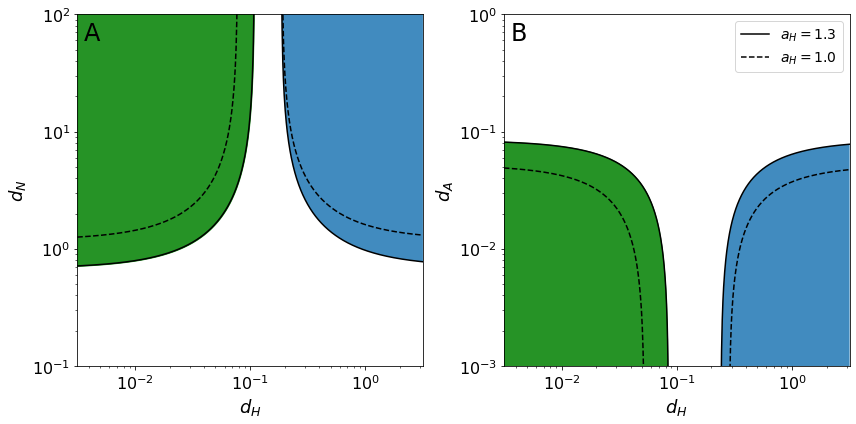

In [14]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot2grid((1,2),(0,0))

ax1.loglog(dHvals,dNvals1,'k')
ax1.loglog(dHvals,dNvals2,'k')

ax1.loglog(dHvals,dNvals1a,'k--')
ax1.loglog(dHvals,dNvals2a,'k--')

ax1.fill_between(dHvals, dNvals1, 1000,  alpha=0.85)
ax1.fill_between(dHvals, dNvals2, 1000, color='green', alpha=0.85)
ax1.text(.02, .98, 'A', ha='left', va='top', transform=ax1.transAxes,fontsize=24)
ax1.set_ylim(1e-1,1e2)
ax1.set_xlim(pow(10,-2.5),pow(10,0.5))
ax1.set_xlabel(r'$d_{H}$',fontsize=18)
ax1.set_ylabel(r'$d_{N}$',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = plt.subplot2grid((1,2),(0,1))

ax2.loglog(dHvals,dAvals1,'k',label=r'$a_H=1.3$')
ax2.loglog(dHvals,dAvals2,'k')

ax2.loglog(dHvals,dAvals1a,'k--',label=r'$a_H=1.0$')
ax2.loglog(dHvals,dAvals2a,'k--')

ax2.fill_between(dHvals, dAvals1, 0, alpha=0.85)
ax2.fill_between(dHvals, dAvals2, 0, color='green', alpha=0.85)
ax2.text(.02, .98, 'B', ha='left', va='top', transform=ax2.transAxes,fontsize=24)
ax2.set_ylim(1e-3,1e0)
ax2.set_xlim(pow(10,-2.5),pow(10,0.5))
ax2.set_xlabel(r'$d_{H}$',fontsize=18)
ax2.set_ylabel(r'$d_{A}$',fontsize=18)

ax2.legend(fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.savefig('Figure_S4.png',dpi=300);

In [15]:
Lx = 500
Ly = 501
dHvals = np.logspace(-2,0.5,Lx)
dNvals = np.logspace(-1,2,Ly)

X, Y = np.meshgrid(dHvals,dNvals)

dAvals1 = np.zeros((Ly,Lx))
dAvals2 = np.zeros((Ly,Lx))

x01 = 1
x02 = 1
i = 0
j = 0
for dH in dHvals:
    for dN in dNvals:
        x01 = 1
        x02 = 1
        sol1 = root(c1_dA,x01).x[0]
        sol2 = root(c3_dA,x02).x[0]

        x01 = sol1     # for boundaries in d_H-d_N-space, it is best to 'continue' solutions found
        x02 = sol2
        
        if sol1 < 0:
            sol1 = 'nan'
        elif sol1 < 1e-3:
            sol1 = 1e-3#1000
        if sol2 < 0:
            sol2 ='nan'#1000
        elif sol2 < 1e-3:
            sol2 =1e-3#1000
    
        dAvals1[j,i] = sol1           # sTI in d_H-d_N-d_A space
        dAvals2[j,i] = sol2           # oTI in d_H-d_N-d_A space
        
        j += 1
        
    j = 0    
    i += 1


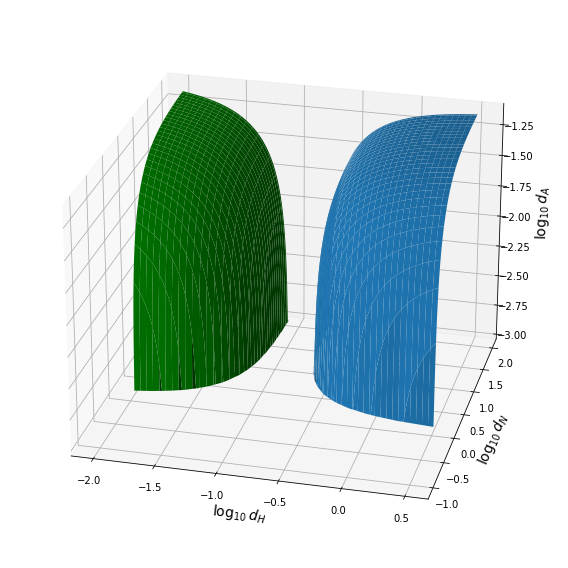

In [16]:
fig, ax = plt.subplots(figsize=(10,8),subplot_kw={"projection": "3d"})

surf1 = ax.plot_surface(np.log10(X), np.log10(Y), np.log10(dAvals1),  linewidth=0.5, antialiased=True)
surf2 = ax.plot_surface(np.log10(X), np.log10(Y), np.log10(dAvals2),  linewidth=0.5, antialiased=True, color='green')

ax.set_xlabel(r'$\log_{10}d_H$',fontsize=14)
ax.set_ylabel(r'$\log_{10}d_N$',fontsize=14)
ax.set_zlabel(r'$\log_{10}d_A$',fontsize=14)
ax.zaxis.labelpad=10
ax.view_init(25, 284)

plt.tight_layout()
plt.savefig('Figure_2.png',dpi=300);

## Fig. S5: Turing boundaries under variation of different parameters

In [17]:
# homogeneous fixed point (= fixed point of the one-patch system)
def FP_Monod():
    Astar = D/(a*(e-D*h))
    p = Nh + rmax*Astar/D - S
    Nstar = -0.5*p + m.sqrt(0.25*p*p + S*Nh)
    Hstar = (rmax*Nstar/(Nh+Nstar) - D)*(1/a + h*Astar)
    
    return Nstar,Astar,Hstar

def local_Jacobian_Monod(Nstar,Astar,Hstar,h,Nh):
    t1 = 1/(Nh+Nstar)
    t2 = 1/(1+a*h*Astar)
    t3 = rmax*Astar*Nh*t1*t1
    t4 = rmax*Nstar*t1
    t5 = a*Hstar*t2*t2
    t6 = a*Astar*t2

    return np.array([[-D-t3,-t4,0],[t3,t4-D-t5,-t6],[0,e*t5,0]])

def diffusion_Jacobian_plastic(dN,dA,dH,kH):
    dHmax = 2*dH
    A_crit = D/(aS*(e-h*D))
    d1 = m.exp(kH*(Astar-A_crit))
    d2 = dHmax / (1+d1)
    d3 = d2*d1*Hstar*kH / (1+d1)

    return np.array([[dN,0,0],[0,dA,0],[0,-d3,d2]]) 


def T_mat_Monod(dN,dA,dH,kH,h,Nh):
    
    J_mat = local_Jacobian_Monod(Nstar,Astar,Hstar,h,Nh)
    D_mat = diffusion_Jacobian_plastic(dN,dA,dH,kH)
    
    return J_mat - 2*D_mat    

# function that returns the coefficients of lambda**3 + b2*lambda**2 + b1*lambda + b0 = 0 
def coefs_Monod(dN,dA,dH,kH,h,Nh):
    a11, a12, a21 = T_mat_Monod(dN,dA,dH,kH,h,Nh)[0][0], T_mat_Monod(dN,dA,dH,kH,h,Nh)[0][1], T_mat_Monod(dN,dA,dH,kH,h,Nh)[1][0]
    a22, a23, a32 = T_mat_Monod(dN,dA,dH,kH,h,Nh)[1][1], T_mat_Monod(dN,dA,dH,kH,h,Nh)[1][2], T_mat_Monod(dN,dA,dH,kH,h,Nh)[2][1]
    a33 = T_mat_Monod(dN,dA,dH,kH,h,Nh)[2][2]
    
    b0 = a12*a21*a33 + a11*a23*a32 - a11*a22*a33
    b1 = (a11+a22)*a33 + a11*a22 - a12*a21 - a23*a32
    b2 = -(a11+a22+a33)
    
    return [b0,b1,b2]

# coefficients as functions of single parameters
def coefs_dH_Monod(dH):
    return coefs_Monod(dN,dA,dH,kH,h,Nh)

def c1_dH_Monod(dH):    
    return coefs_dH_Monod(dH[0])[0]

def c3_dH_Monod(dH):    
    return coefs_dH_Monod(dH[0])[1]*coefs_dH_Monod(dH[0])[2] - coefs_dH_Monod(dH[0])[0]

def coefs_kH_Monod(kH):
    return coefs_Monod(dN,dA,dH,kH,h,Nh)

def c1_kH_Monod(kH):  # yields curved line at high d_H
    return coefs_kH_Monod(kH[0])[0]



In [18]:
# find zeros of Ruth-Hurwitz-criteria via root-finding -> these are the Turing boundaries
S = 5
D = 0.3
a = 1.3
h = 0.5
e = 0.33
r = 0.5

dN = 4
dA = 0.004
kH = 0

hvals = np.linspace(0,1,1000)     # gradient of h-values
Nhvals = np.logspace(-1,3,1000)   # gradient of Nh-values
kHvals = np.linspace(0,5,10)      # gradient of kH-values
dHvals = np.logspace(-1,1,1000)   # gradient of dH-values

dHvals1_h = []
dHvals2_h = []

dHvals1_Nh = []
dHvals2_Nh = []

kvals1 = []
dHvals2_kH = []

Nh = 1e4                       # these numbers guarantee an essentially linear nutrient uptake rate
rmax = r*Nh

for h in hvals:
    Nstar, Astar, Hstar = FP_Monod()
    
    sol1 = root(c1_dH_Monod,0.5).x[0]
    sol2 = root(c3_dH_Monod,0.01).x[0]

    # dummy values for solution, if no values can be calculated
    if sol1 < 0:
        sol1 = 1e8
    if sol2 < 0:
        sol2 =0
    if Hstar < 0:
        sol1 = 1e4

    
    dHvals1_h.append(sol1)           # sTI in dH-h space
    dHvals2_h.append(sol2)           # oTI in dH-h space

h = 0.5
for Nh in Nhvals:
    rmax = r*Nh
    Nstar, Astar, Hstar = FP_Monod()
    
    sol1 = root(c1_dH_Monod,100).x[0]
    sol2 = root(c3_dH_Monod,0.1).x[0]
    
    if sol1 < 0:
        sol1 = 40
    if Hstar < 0:
        sol1 = 40#'nan'
        
    dHvals1_Nh.append(sol1)           # sTI in dH-Nh space
    dHvals2_Nh.append(sol2)           # oTI in dH-Nh space
    
Nh = 1e4                       # these numbers guarantee an essentially linear nutrient uptake rate
rmax = r*Nh
for kH in kHvals:
    sol2 =root(c3_dH_Monod,0.05).x[0]
    dHvals2_kH.append(sol2)           # oTI in d_max,S-k_S space    
    
for dH in dHvals:    
    sol1 = root(c1_kH_Monod,1).x[0]
    kvals1.append(sol1)            # sTI in d_max,S-k_S space


In [19]:
# find zeros of Ruth-Hurwitz-criteria via root-finding -> these are the Turing boundaries
S = 5
D = 0.3
a = 1.3
h = 0.5
e = 0.33
r = 0.5

dN = 4
dA = 0.004
kH = 0

evals = np.linspace(0.2,0.5,1000)   # gradient of e-values
rvals = np.linspace(0,1.5,1000)     # gradient of r-values
avals = np.linspace(0.3,2.2,1000)   # gradient of a-values

dHvals1_e = []
dHvals2_e = []

dHvals1_r = []
dHvals2_r = []

dHvals1_a = []
dHvals2_a = []


for e in evals:
    Nstar, Astar, Hstar = FP()
    
    sol1 = root(c1_dH,0.5).x[0]
    sol2 = root(c3_dH,0.01).x[0]

    # dummy values for solution, if no values can be calculated
    if sol1 < 0:
        sol1 = 1e8
    if sol2 < 0:
        sol2 =0
    if Hstar < 0:
        sol1 = 1e4

    
    dHvals1_e.append(sol1)           # sTI in dH-e space
    dHvals2_e.append(sol2)           # oTI in dH-e space

e = 0.33
for r in rvals:
    Nstar, Astar, Hstar = FP()
    
    sol1 = root(c1_dH,100).x[0]
    sol2 = root(c3_dH,0.1).x[0]
    
    if sol1 < 0:
        sol1 = 40
    if Hstar < 0:
        sol1 = 40#'nan'
        
    dHvals1_r.append(sol1)           # sTI in dH-r space
    dHvals2_r.append(sol2)           # oTI in dH-r space
    
r = 0.5
for a in avals:
    Nstar, Astar, Hstar = FP()
    
    sol1 = root(c1_dH,0.5).x[0]
    sol2 = root(c3_dH,0.01).x[0]

    # dummy values for solution, if no values can be calculated
    if sol1 < 0:
        sol1 = 1e8
    if sol2 < 0:
        sol2 =0
    if Hstar < 0:
        sol1 = 1e4

    
    dHvals1_a.append(sol1)           # sTI in dH-e space
    dHvals2_a.append(sol2)           # oTI in dH-e space

    

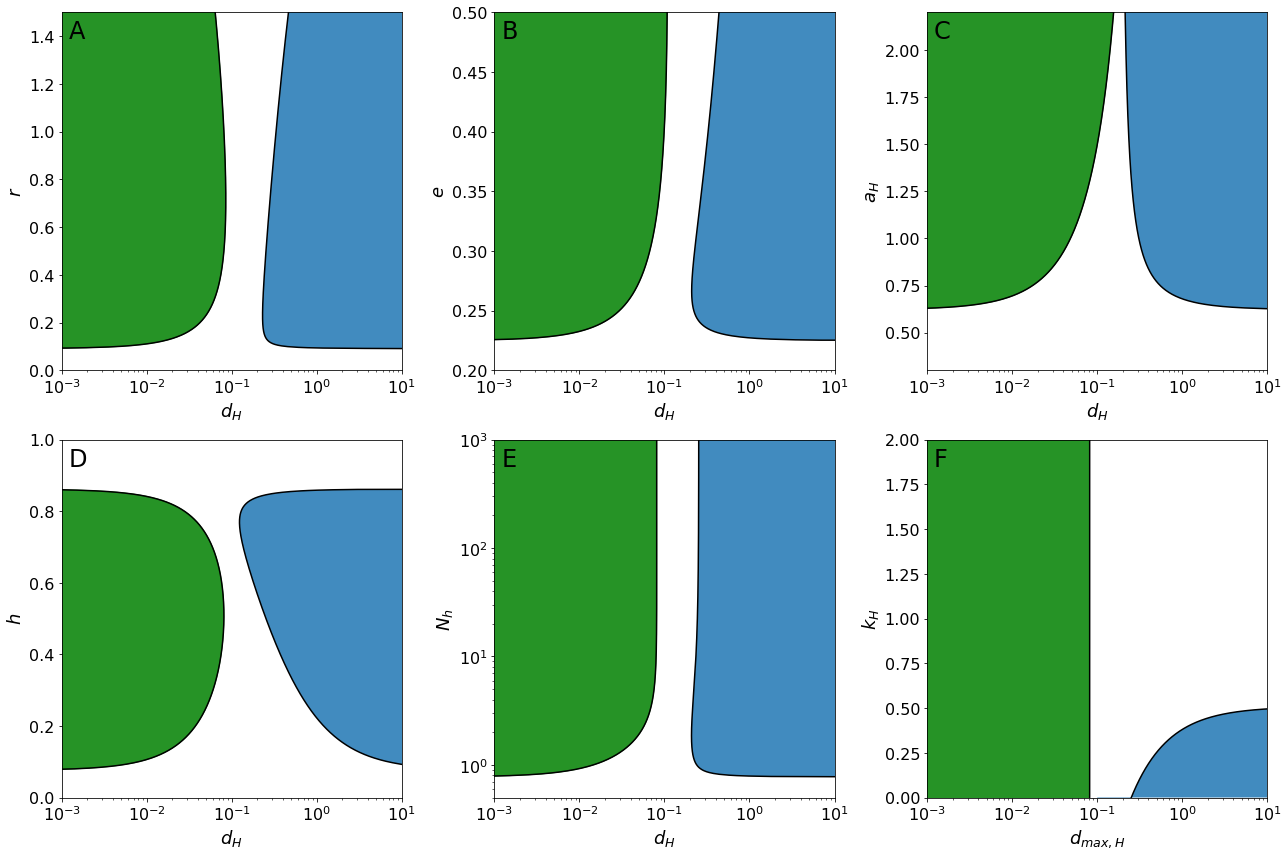

In [20]:
fig = plt.figure(figsize=(18,12))

ax1 = plt.subplot2grid((2,3),(0,0))

ax1.plot(dHvals1_r,rvals,'k')
ax1.plot(dHvals2_r,rvals,'k')

ax1.fill_between(dHvals1_r, rvals, 1e4, alpha=0.85)
ax1.fill_between(dHvals2_r, rvals, 1e4, color='green', alpha=0.85)
ax1.set_xlabel(r'$d_{H}$',fontsize=18)
ax1.set_ylabel(r'$r$',fontsize=18)
ax1.set_xscale('log')
ax1.set_xlim(1e-3,1e1)
ax1.set_ylim(0,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.text(.02, .98, 'A', ha='left', va='top', transform=ax1.transAxes,fontsize=24)


ax2 = plt.subplot2grid((2,3),(0,1))

ax2.semilogx(dHvals1_e,evals,'k')
ax2.semilogx(dHvals2_e,evals,'k')

ax2.fill_between(dHvals1_e, evals, 10, alpha=0.85)
ax2.fill_between(dHvals2_e, evals, 10, color='green', alpha=0.85)
ax2.set_ylim(0.2,0.5)
ax2.set_xlim(1e-3,1e1)
ax2.set_xlabel(r'$d_{H}$',fontsize=18)
ax2.set_ylabel(r'$e$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax2.text(.02, .98, 'B', ha='left', va='top', transform=ax2.transAxes,fontsize=24)


ax3 = plt.subplot2grid((2,3),(0,2))

ax3.plot(dHvals1_a,avals,'k')
ax3.plot(dHvals2_a,avals,'k')

ax3.fill_between(dHvals1_a, avals, 1e4, alpha=0.85)
ax3.fill_between(dHvals2_a, avals, 1e4, color='green', alpha=0.85)
ax3.text(.02, .98, 'C', ha='left', va='top', transform=ax3.transAxes,fontsize=24)

ax3.set_xscale('log')
ax3.set_xlim(0.0007,15)
ax3.set_ylim(0.3,2.2)
ax3.set_xlabel(r'$d_H$',fontsize=18)
ax3.set_ylabel(r'$a_{H}$',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax3.set_xlim(1e-3,1e1)


ax4 = plt.subplot2grid((2,3),(1,0))

ax4.semilogx(dHvals1_h,hvals,'k')
ax4.semilogx(dHvals2_h,hvals,'k')

ax4.fill_between(dHvals1_h, hvals, 10, alpha=0.85)
ax4.fill_between(dHvals2_h, hvals, 10, color='green', alpha=0.85)
ax4.set_ylim(0,1)
ax4.set_xlim(1e-3,1e1)
ax4.set_xlabel(r'$d_{H}$',fontsize=18)
ax4.set_ylabel(r'$h$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax4.text(.02, .98, 'D', ha='left', va='top', transform=ax4.transAxes,fontsize=24)


ax5 = plt.subplot2grid((2,3),(1,1))

ax5.plot(dHvals1_Nh,Nhvals,'k')
ax5.plot(dHvals2_Nh,Nhvals,'k')

ax5.fill_between(dHvals1_Nh, Nhvals, 1e4, alpha=0.85)
ax5.fill_between(dHvals2_Nh, Nhvals, 1e4, color='green', alpha=0.85)
ax5.set_xlabel(r'$d_{H}$',fontsize=18)
ax5.set_ylabel(r'$N_{h}$',fontsize=18)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlim(1e-3,1e1)
ax5.set_ylim(0.5,1000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax5.text(.02, .98, 'E', ha='left', va='top', transform=ax5.transAxes,fontsize=24)


ax6 = plt.subplot2grid((2,3),(1,2))

ax6.plot(dHvals,kvals1,'k')
ax6.plot(dHvals2_kH,kHvals,'k')

ax6.fill_between(dHvals,kvals1,0, alpha=0.85)
ax6.fill_between([1e-3,0.081],[0,0],100, color='green', alpha=0.85)
ax6.text(.02, .98, 'F', ha='left', va='top', transform=ax6.transAxes,fontsize=24)

ax6.set_xscale('log')
ax6.set_ylim(0,2)
ax6.set_xlabel(r'$d_{max,H}$',fontsize=18)
ax6.set_ylabel(r'$k_{H}$',fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax6.set_xlim(1e-3,1e1)


plt.tight_layout()
plt.savefig('Figure_S5.png',dpi=300);